# Подготовительные действия

In [1]:
from utils import *

In [2]:
t = Timer()

# Загрузка и фильтр рецензий

## Загрузка рецензий из SCV-файла

In [3]:
import pandas as pd

In [4]:
reviews_df = pd.read_csv('reviews.csv', sep='\t')
reviews_df.shape

(256509, 2)

## Фильтр рецензий

Нейтральные рецензии не нужны для обучения модели, поэтому они удаляются

In [5]:
reviews_df.drop(reviews_df[reviews_df.mark == 'NEUTRAL'].index, inplace=True)
reviews_df.shape

(214542, 2)

Положительные рецензии маркируются цифрой 1, отрицательные - цифрой 0

In [6]:
reviews_df.mark.replace({'NEGATIVE': 0, 
                         'POSITIVE': 1}, inplace=True)

## Токенизация рецензий

### Загрузка словаря имен

In [7]:
import pickle

In [8]:
with open('token_dict.pkl', 'rb') as file:
    words = pickle.load(file)

### Преобразование рецензий в токены

In [9]:
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
TOKEN_RE = re.compile(r'(?:[\w\d]+\-[\w\d]+)|[\w\d]+')

In [11]:
t.start()

tokenized = [(TOKEN_RE.findall(review.lower()), mark) 
             for review, mark 
             in zip(reviews_df.review.to_list(), reviews_df.mark.to_list())]

t.stop()

Завершено за 00:02:9.416


### Преобразование токенов в идентификаторы

In [12]:
t.start()

tokenized_ids = [([words[token] 
                   for token in tokens 
                   if token in words], mark) 
                 for tokens, mark in tokenized]

t.stop()

Завершено за 00:01:54.11


# Составление обучающей выборки

## Фильтр длинных рецензий

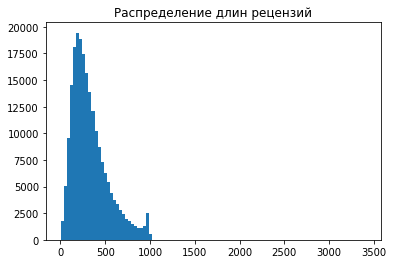

In [13]:
plt.title('Распределение длин рецензий')
plt.hist(list(map(lambda review: len(review[0]), tokenized_ids)), bins=100);

Согласно графику распределения, не лишним будет убрать все рецензии, длина которых больше 1000 токенов, поскольку они не очень важны в рамках статистики, но при этом занимают много памяти

In [14]:
t.start()

tokenized_sub_1000 = [(tokens, mark)
                      for tokens, mark in tokenized_ids 
                      if len(tokens) <= 1000]

t.stop()

Завершено за 00:00:42.291


Разделение рецензий на положительные и отрицательные

In [15]:
tokenized_sub_1000_pos = [review for review in tokenized_sub_1000 if review[1] == 1]
tokenized_sub_1000_neg = [review for review in tokenized_sub_1000 if review[1] == 0]

Статистика по количеству положительных и отрицательных рецензий

In [16]:
all_num = len(tokenized_sub_1000)
pos_num = len(tokenized_sub_1000_pos)
neg_num = len(tokenized_sub_1000_neg)

In [17]:
nums = [pos_num, neg_num]
data = {'класс': ['Позитивные', 'Негативные'], 
        'число': nums, 
        'доля': [f'{round(num / all_num * 100)}%' for num in nums]}

pd.DataFrame(data).style.hide_index()

класс,число,доля
Позитивные,188820,88%
Негативные,25430,12%


## Составление выборки

In [18]:
import random

Итоговая обучающая выборка будет состоять из 50'000 рецензий, из которых 25'000 положительных и столько же отрицательных

In [19]:
POS_COUNT = 25000
NEG_COUNT = 25000

In [20]:
tokenized_sub_1000_pos = random.sample(tokenized_sub_1000_pos, POS_COUNT)
tokenized_sub_1000_neg = random.sample(tokenized_sub_1000_neg, NEG_COUNT)

assert len(tokenized_sub_1000_pos) == POS_COUNT and len(tokenized_sub_1000_neg) == NEG_COUNT

In [21]:
merged_reviews = tokenized_sub_1000_pos + tokenized_sub_1000_neg
random.shuffle(merged_reviews)

assert len(merged_reviews) == POS_COUNT + NEG_COUNT

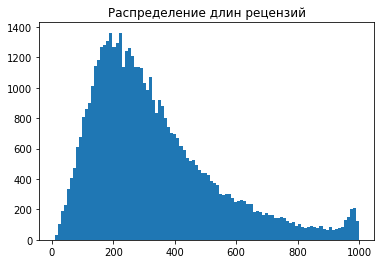

In [22]:
plt.title('Распределение длин рецензий')
plt.hist(list(map(lambda review: len(review[0]), merged_reviews)), bins=100);

# Сохранение обучающей выборки

In [23]:
with open('filtred_reviews.pkl', 'wb') as file:
    pickle.dump(merged_reviews, file)